In [6]:
import os
from datetime import datetime

import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [7]:
# Select latest data file
folder = '../data/'
files = [file for file in os.listdir(folder) if not file.startswith('.~lock')]
most_recent_data_file = max(files, key=lambda x: datetime.strptime(x.split('-')[0] + x.split('-')[1] + x.split('-')[2] + " " + x.split('-')[3] + ":" + x.split('-')[4] + ":" + x.split('-')[5], '%Y%m%d %H:%M:%S'))
data_file = folder + most_recent_data_file
print("Data file: {}".format(data_file))

Data file: ../data/2025-03-08-11-01-06-data-up-to-865042-K-208-chi-4032-k-323-completed.json


In [8]:
# Load data into DataFrame
with open(data_file, 'r') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)

In [11]:
# Is df[COLUMN] monotonically increasing?
print("Is df[COLUMN] monotonically increasing/decreasing?\n")
print(f"df['timestamp']     {str(df['timestamp'].is_monotonic_increasing):5}. Should be False.")
print(f"df['proof_score']   {str(df['proof_score'].is_monotonic_increasing):5}. Should be False.")
print(f"df['proof_size']    {str(df['proof_size'].is_monotonic_increasing):5}. Should be False.")
print(f"df['target']        {str(df['target'].is_monotonic_decreasing):5}. Should be False.")

Is df[COLUMN] monotonically increasing/decreasing?

df['timestamp']     False. Should be False.
df['proof_score']   False. Should be False.
df['proof_size']    False. Should be False.
df['target']        False. Should be False.


In [10]:
# Add block height (index) as column
df["height"] = df.index + 1

In [22]:
# Create datetime objects column from timestamps column
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')
df

,target,proof_size,proof_score,timestamp,proof_generation_latency,height,timestamp_dt
0,2695953529101130949315647634472399133601089873...,1,1,1231006505,0.076532,1,2009-01-03 18:15:05
1,2695953529101130949315647634472399133601089873...,2,2,1231469665,0.013828,2,2009-01-09 02:54:25
2,2695953529101130949315647634472399133601089873...,3,3,1231469744,0.008583,3,2009-01-09 02:55:44
3,2695953529101130949315647634472399133601089873...,4,4,1231470173,0.006676,4,2009-01-09 03:02:53
4,2695953529101130949315647634472399133601089873...,5,5,1231470988,0.006914,5,2009-01-09 03:16:28
...,...,...,...,...,...,...,...
865038,2928805436162009520992638294218449682899899138...,7078,568293691178182364,1728572242,3.298283,865039,2024-10-10 14:57:22
865039,2928805436162009520992638294218449682899899138...,7077,568206797443176909,1728572873,3.093243,865040,2024-10-10 15:07:53
865040,2928805436162009520992638294218449682899899138...,7078,568298847037725394,1728573656,3.066063,865041,2024-10-10 15:20:56
865041,2928805436162009520992638294218449682899899138...,7076,568122481637942969,1728574093,3.102303,865042,2024-10-10 15:28:13


In [23]:
# Add Genesis target and difficulty column
genesis_target = 26959535291011309493156476344723991336010898738574164086137773096960
df['difficulty'] = genesis_target / df['target']
df['difficulty'] = df['difficulty'].astype(float)
df

,target,proof_size,proof_score,timestamp,proof_generation_latency,height,timestamp_dt,difficulty
0,2695953529101130949315647634472399133601089873...,1,1,1231006505,0.076532,1,2009-01-03 18:15:05,1.000000e+00
1,2695953529101130949315647634472399133601089873...,2,2,1231469665,0.013828,2,2009-01-09 02:54:25,1.000000e+00
2,2695953529101130949315647634472399133601089873...,3,3,1231469744,0.008583,3,2009-01-09 02:55:44,1.000000e+00
3,2695953529101130949315647634472399133601089873...,4,4,1231470173,0.006676,4,2009-01-09 03:02:53,1.000000e+00
4,2695953529101130949315647634472399133601089873...,5,5,1231470988,0.006914,5,2009-01-09 03:16:28,1.000000e+00
...,...,...,...,...,...,...,...,...
865038,2928805436162009520992638294218449682899899138...,7078,568293691178182364,1728572242,3.298283,865039,2024-10-10 14:57:22,9.204959e+13
865039,2928805436162009520992638294218449682899899138...,7077,568206797443176909,1728572873,3.093243,865040,2024-10-10 15:07:53,9.204959e+13
865040,2928805436162009520992638294218449682899899138...,7078,568298847037725394,1728573656,3.066063,865041,2024-10-10 15:20:56,9.204959e+13
865041,2928805436162009520992638294218449682899899138...,7076,568122481637942969,1728574093,3.102303,865042,2024-10-10 15:28:13,9.204959e+13


In [24]:
df.dtypes

target                              object
proof_size                           int64
proof_score                          int64
timestamp                            int64
proof_generation_latency           float64
height                               int64
timestamp_dt                datetime64[ns]
difficulty                         float64
dtype: object

In [25]:
# DataFrame description
df.describe()

,proof_size,proof_score,timestamp,proof_generation_latency,height,difficulty
count,865043.000000,8.650430e+05,8.650430e+05,865043.000000,865043.000000,8.650430e+05
mean,6868.301546,7.509737e+16,1.478748e+09,2.620522,432522.000000,1.225804e+13
std,474.652823,1.320413e+17,1.410821e+08,0.608911,249716.548793,2.147582e+13
min,1.000000,1.000000e+00,1.231007e+09,0.005245,1.000000,1.000000e+00
25%,6739.000000,1.962662e+10,1.358011e+09,2.316713,216261.500000,3.368767e+06
50%,6976.000000,1.380875e+15,1.475408e+09,2.727032,432522.000000,2.412272e+11
75%,7114.000000,1.054927e+17,1.600365e+09,3.055096,648782.500000,1.678778e+13
max,7440.000000,5.731516e+17,1.728574e+09,6.843090,865043.000000,9.267158e+13


/tmp/ipykernel_14773/620208664.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


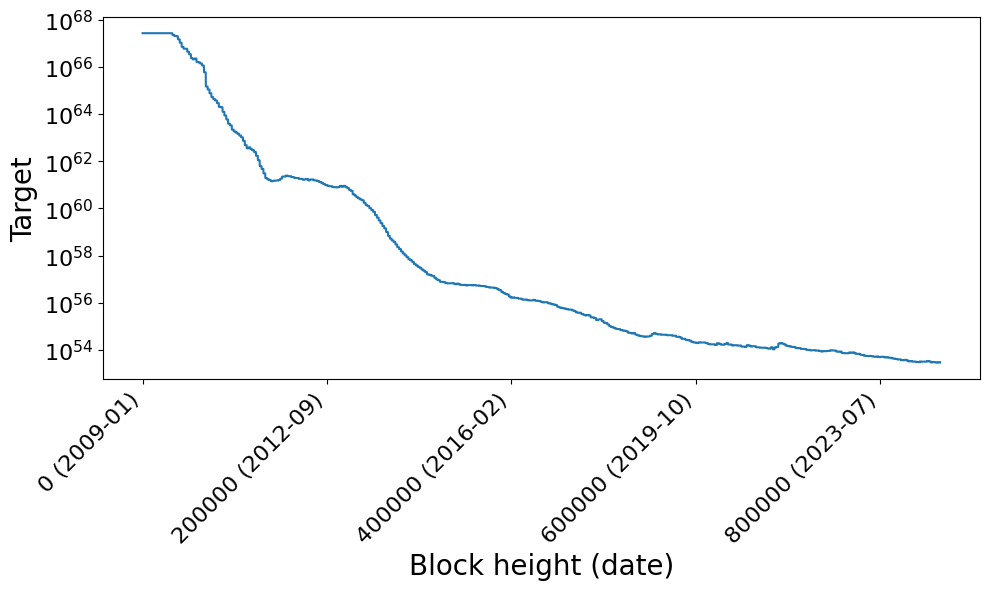

In [26]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Target', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("target-variation-over-time.pdf", format="pdf")
plt.show()

/tmp/ipykernel_14773/3681305100.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


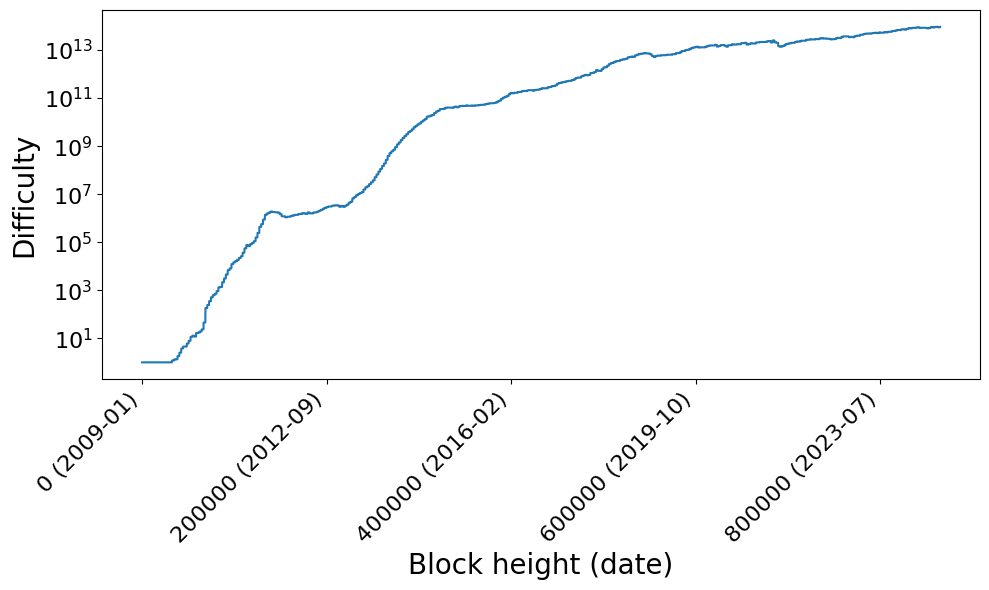

In [27]:
# Plot difficulty over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['difficulty'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Difficulty', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("difficulty-variation-over-time.pdf", format="pdf")
plt.show()

In [33]:
# Number of times the target increases, and their heights
target_increases_count = 0
target_increases_heights = []
prev_target = None
for i, target in enumerate(df['target']):
    if prev_target is not None and target > prev_target:
        target_increases_count += 1
        target_increases_heights.append(df['height'][i] - 1)  # Subtract 1 to get the height of the block that caused the increase
    prev_target = target
target_increases_count_percent = target_increases_count / (len(df)/2016) * 100

print(f"Target increases {target_increases_count} times ({target_increases_count_percent:.2f}%) out of {len(df)/2016} epochs.")
print(f"Target increases heights: {target_increases_heights}")

# Are the target increases heights multiples of 2016?
target_increases_heights_multiples = [height % 2016 == 0 for height in target_increases_heights]
print(f"Are the target increases heights multiples of 2016? {target_increases_heights_multiples}")

Target increases 90 times (20.97%) out of 429.0887896825397 epochs.
Target increases heights: [56448, 114912, 141120, 143136, 145152, 147168, 149184, 151200, 153216, 155232, 167328, 175392, 177408, 181440, 183456, 211680, 213696, 217728, 332640, 334656, 340704, 348768, 352800, 358848, 362880, 401184, 409248, 415296, 423360, 435456, 473760, 481824, 493920, 495936, 532224, 546336, 550368, 552384, 554400, 560448, 566496, 572544, 580608, 586656, 602784, 606816, 618912, 622944, 631008, 633024, 637056, 641088, 647136, 651168, 655200, 661248, 663264, 673344, 681408, 685440, 687456, 689472, 691488, 711648, 725760, 727776, 731808, 737856, 741888, 743904, 745920, 756000, 762048, 766080, 770112, 776160, 788256, 796320, 800352, 806400, 820512, 826560, 832608, 836640, 842688, 846720, 848736, 850752, 856800, 862848]
Are the target increases heights multiples of 2016? [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

/tmp/ipykernel_14773/798735610.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


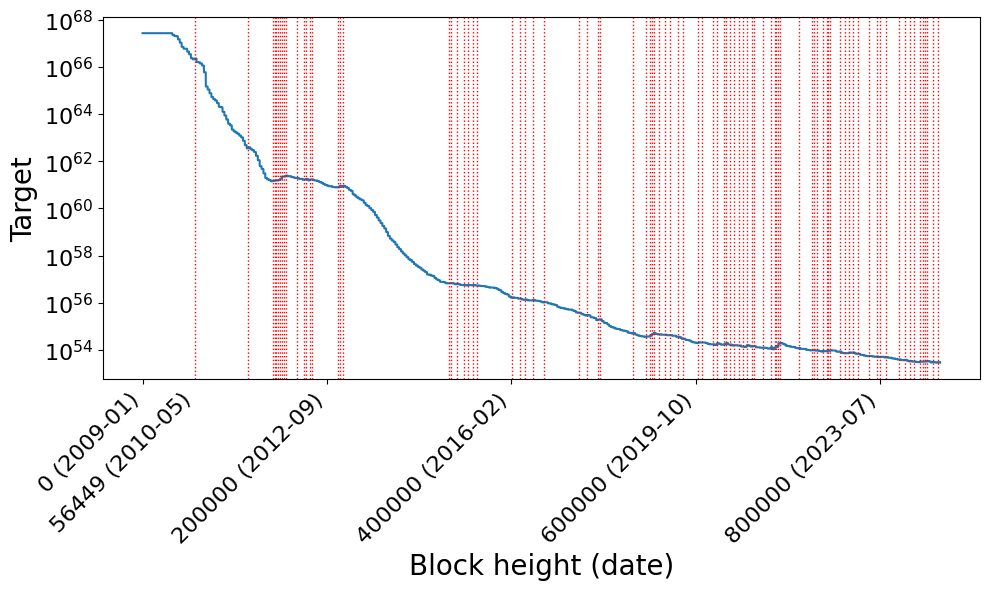

In [12]:
# Plot target over time with target increases
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Target', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

# Add vertical red lines when target increases
prev_target = None
first_line_label = False
for i, target in enumerate(df['target']):
    if prev_target is not None and target > prev_target:
        # print(df.iloc[i]['height']) # print block heights of red lines
        plt.axvline(x=df.iloc[i]['height'], color='red', linestyle=':', linewidth=1)
        if not first_line_label:
            plt.text(df.iloc[i]['height'], -0.025, f"{df.iloc[i]['height']} ({df.iloc[i]['timestamp_dt'].strftime('%Y-%m')})", transform=plt.gca().get_xaxis_transform(), ha='right', va='top', rotation=45, color='black', size=16)
            first_line_label = True
    prev_target = target

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("target-variation-over-time-with-increases.pdf", format="pdf")
plt.show()

/tmp/ipykernel_14773/3021322120.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


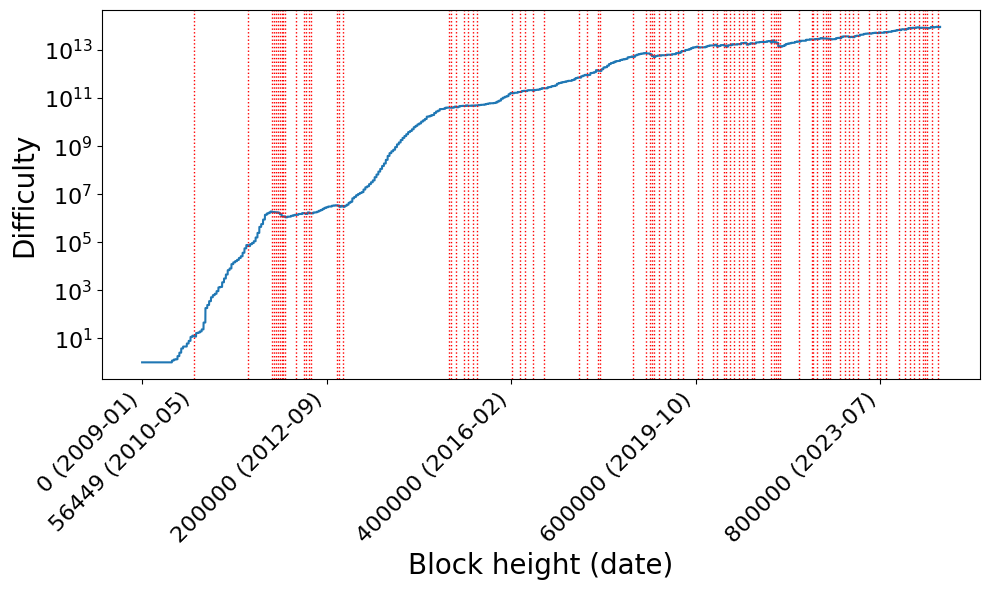

In [15]:
# Plot difficulty over time with difficulty decreases
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['difficulty'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Difficulty', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

# Add vertical red lines when difficulty decreases
prev_difficulty = None
first_line_label = False
for i, difficulty in enumerate(df['difficulty']):
    if prev_difficulty is not None and difficulty < prev_difficulty:
        # print(df.iloc[i]['height']) # print block heights of red lines
        plt.axvline(x=df.iloc[i]['height'], color='red', linestyle=':', linewidth=1)
        if not first_line_label:
            plt.text(df.iloc[i]['height'], -0.025, f"{df.iloc[i]['height']} ({df.iloc[i]['timestamp_dt'].strftime('%Y-%m')})", transform=plt.gca().get_xaxis_transform(), ha='right', va='top', rotation=45, color='black', size=16)
            first_line_label = True
    prev_difficulty = difficulty

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("difficulty-variation-over-time-with-drops.pdf", format="pdf")
plt.show()

/tmp/ipykernel_115270/3764209552.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


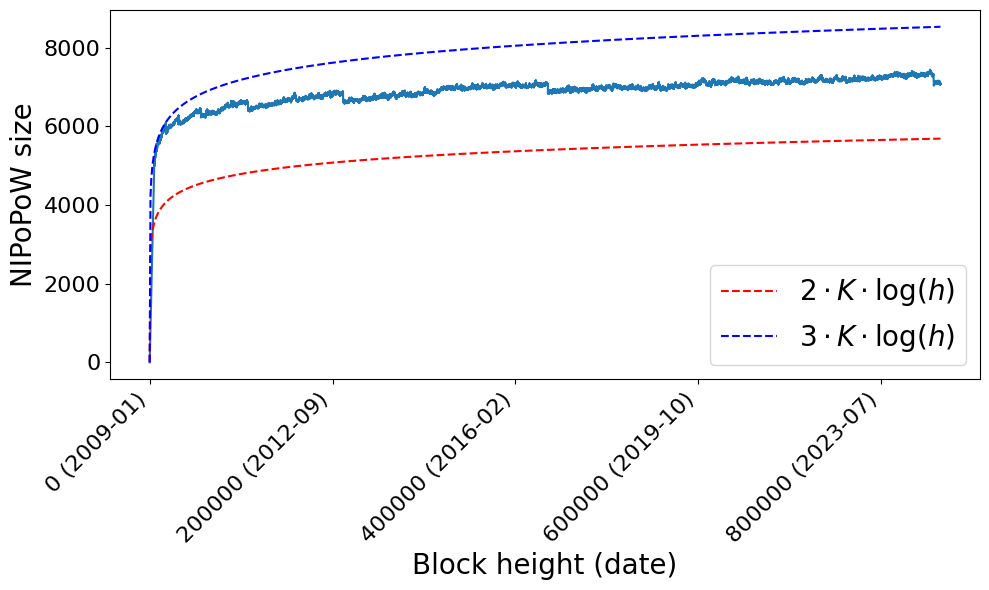

In [11]:
import numpy as np

K = 208

# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_size'], estimator=None, sort=False)

# Add lines for functions 2*K*log(x) and 3*K*log(x)
x_vals = np.linspace(df['height'].min(), df['height'].max(), 1000)  # Generate x values (block heights) for the log functions
y_vals_1 = 2 * K * np.log(x_vals)  # 2 * K * log(x)
y_vals_2 = 3 * K * np.log(x_vals)  # 3 * K * log(x)

# Use LaTeX notation with K in the label
plt.plot(x_vals, y_vals_1, label=r'$2 \cdot K \cdot \log(h)$', linestyle='--', color='red')
plt.plot(x_vals, y_vals_2, label=r'$3 \cdot K \cdot \log(h)$', linestyle='--', color='blue')

plt.xlabel('Block height (date)', size=20)
plt.ylabel('NIPoPoW size', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)

corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])

new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.legend(fontsize=20, loc='lower right')
plt.tight_layout()
plt.savefig("proof-size-variation-over-time.pdf", format="pdf")
plt.show()

/tmp/ipykernel_115270/1557901075.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


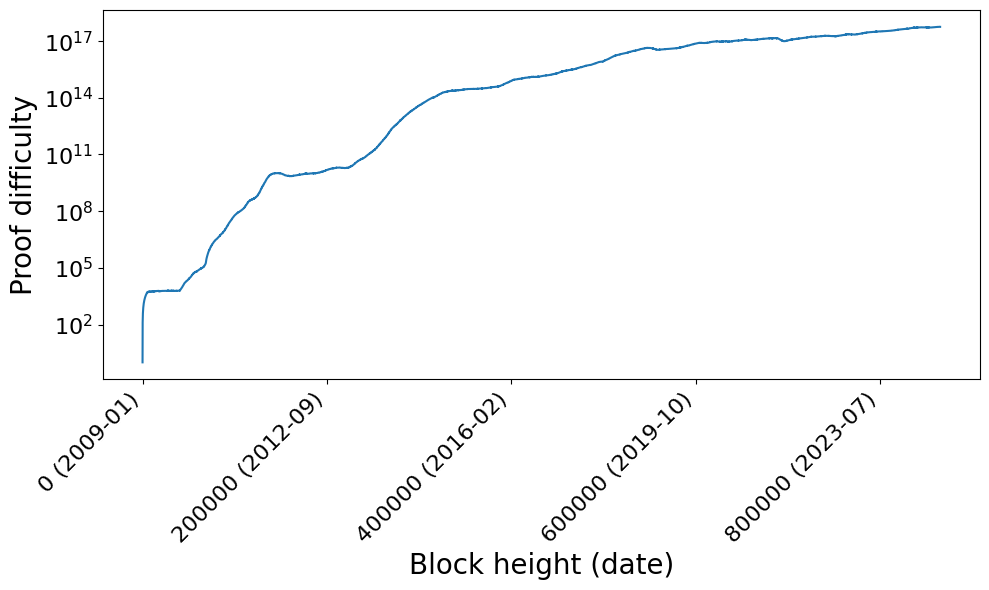

In [12]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Proof difficulty', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("proof-difficulty-variation-over-time-logscale.pdf", format="pdf")
plt.show()

/tmp/ipykernel_115270/2954408213.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


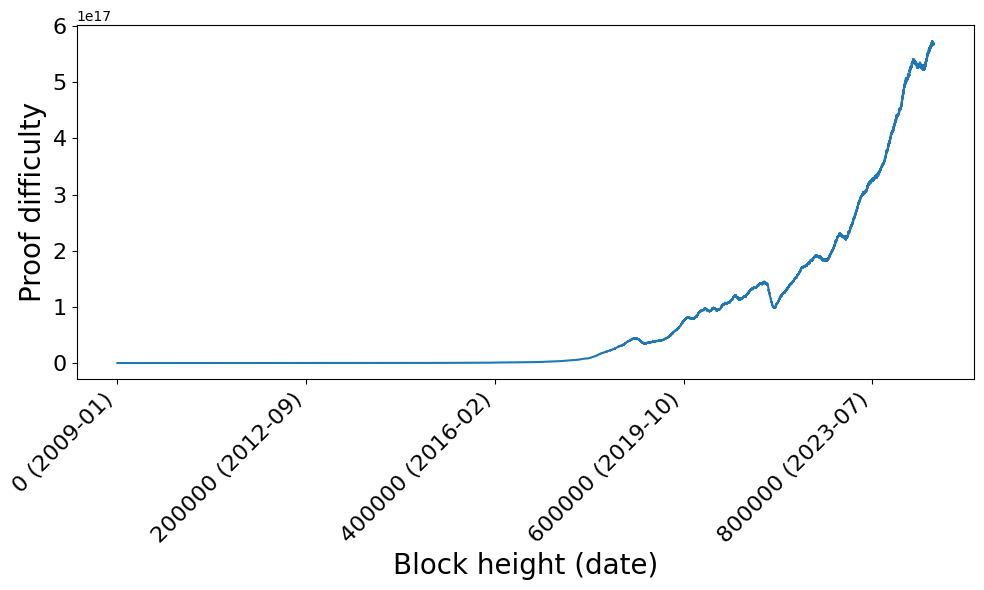

In [13]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Proof difficulty', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("proof-difficulty-variation-over-time.pdf", format="pdf")
plt.show()

/tmp/ipykernel_115270/4134334549.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


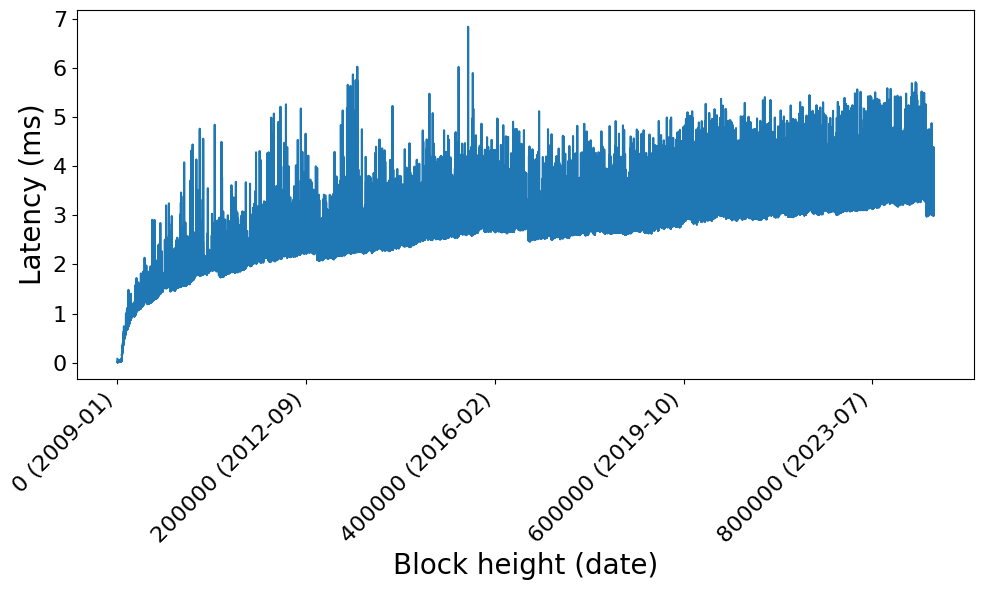

In [15]:
# Plot proof generation latency over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_generation_latency'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Latency (ms)', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("proof-generation-latency-over-time.pdf", format="pdf")
plt.show()

/tmp/ipykernel_115270/3569874622.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


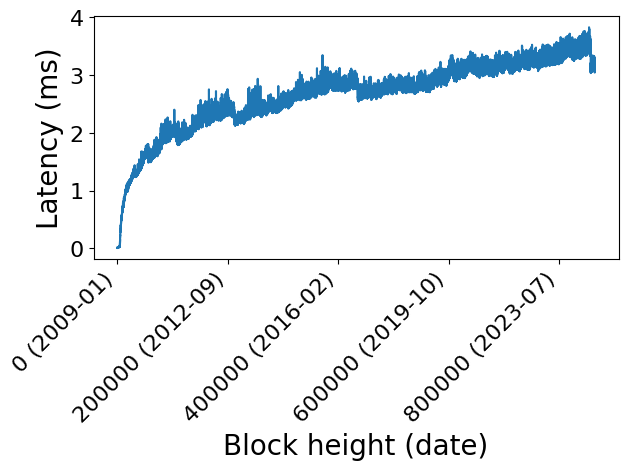

In [19]:
df['smoothed_latency'] = df['proof_generation_latency'].rolling(window=10, center=True).mean()
sns.lineplot(x=df['height'], y=df['smoothed_latency'], estimator=None, sort=False)

plt.xlabel('Block height (date)', size=20)
plt.ylabel('Latency (ms)', size=20)

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)
plt.tight_layout()
plt.savefig("proof-generation-latency-over-time-smoothed.pdf", format="pdf")
plt.show()